In [482]:
import pandas as pd
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.grid_search import GridSearchCV, ParameterGrid

# Shelter Animal Outcome Project

The purpose of the project is to predict outcomes of shelter animals as they leave the Animal Center. The data is form a Kaggle competition: https://www.kaggle.com/c/shelter-animal-outcomes/test I use the data comes from Austin Animal Center (October 1st, 2013 - March, 2016). Outcomes represent the status of animals as they leave the Animal Center.

I come out with a interactive app version of prediction as a final product. I am still working on the development to a website for the app.

In [483]:
#loading the data
animals = pd.read_csv('train.csv')

In [484]:
animals.columns

Index([u'AnimalID', u'Name', u'DateTime', u'OutcomeType', u'OutcomeSubtype',
       u'AnimalType', u'SexuponOutcome', u'AgeuponOutcome', u'Breed',
       u'Color'],
      dtype='object')

LabelEncoder comes very handy to label the outcomes of the data

In [485]:
le_outcome = preprocessing.LabelEncoder()
le_outcome.fit(animals['OutcomeType'])
y = le_outcome.transform(animals['OutcomeType'])
Data = animals.drop(['AnimalID', 'OutcomeType', 'OutcomeSubtype'], axis = 1)

In [486]:
Data.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2/12/14 18:22,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,10/13/13 12:44,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,1/31/15 12:28,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,7/11/14 19:09,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,11/15/13 12:52,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


I seperated sex and neutered data from SexuponOutcome column

In [487]:
def get_sex(x):
    x = str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return 'unknown'
def get_neutered(x):
    x = str(x)
    if x.find('Spayed') >= 0: return 'neutered'
    if x.find('Neutered') >= 0: return 'neutered'
    if x.find('Intact') >= 0: return 'intact'
    return 'unknown'

In [488]:
Data['Sex'] = Data.SexuponOutcome.apply(get_sex)
Data['Neutered'] = Data.SexuponOutcome.apply(get_neutered)

I converted all the age column to normalize them into Year

In [489]:
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0
Data['AgeInYears'] = Data.AgeuponOutcome.apply(calc_age_in_years)

I distinguished the animals with name and without name

In [490]:
Data['Name'] =Data['Name'].fillna(0)
Data.loc[Data['Name'] != 0, "Name"] = 1


The hour of the date and the day of week is drown out from DateTime column

In [491]:
Data['Hour'] = Data.DateTime.map( lambda x: pd.to_datetime(x).hour )
Data['Day_of_Week'] = Data.DateTime.map( lambda x: pd.to_datetime(x).dayofweek )
Data.loc[Data["Day_of_Week"]== 5, "Day_of_Week"] = 8
Data.loc[Data["Day_of_Week"]== 6, "Day_of_Week"] = 8
Data.loc[Data["Day_of_Week"]!= 8, "Day_of_Week"] = 0
Data.loc[Data["Day_of_Week"]== 8, "Day_of_Week"] = 1

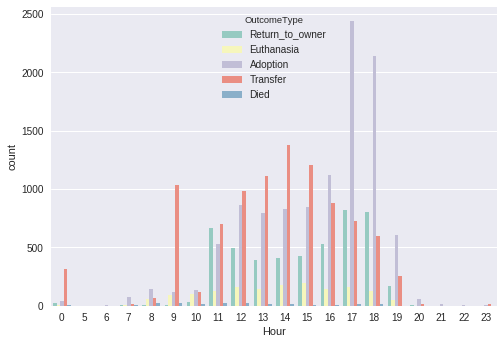

In [492]:
import seaborn as sns
sns.countplot( x=Data['Hour'],hue=animals["OutcomeType"], palette = "Set3")
plt.show()

The animal are adopted more likely at 16-19 and 7-8; transfered at 0, 9, 12-15. 
features: 16and19, 17and18, 7and8, 9, 0, 12and13, 14and15, other_time.

In [493]:
def day(x):
    if x == 16 or x == 19:
        x = "16and19"
    elif x == 17 or x == 18:
        x = "17and18"
    elif x == 7 or x == 8:
        x = "7and8"
    elif x == 12 or x == 13:
        x = "12and13"
    elif x == 14 or x == 15:
        x = "14and15"
    elif x == 9:
        x = "9"
    elif x == 0:
        x = "0"
    else:
        x = "other_time"
    return x
       
Data['Hour'] = Data.Hour.apply(day)

In [494]:
Data['Hour'].unique()

array(['17and18', '12and13', '16and19', '7and8', '14and15', 'other_time',
       '0', '9'], dtype=object)

Since there are too many of animal breed, I included the ones exceed 150

In [495]:
items_counts = Data['Breed'].value_counts()
items_counts[Data['Breed'].value_counts() > 150]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Boxer Mix                     245
Miniature Poodle Mix          233
Border Collie Mix             229
Australian Shepherd Mix       163
Rat Terrier Mix               157
Catahoula Mix                 157
Name: Breed, dtype: int64

In [496]:
my_breeds = ["Domestic Shorthair", "Chihuahua Shorthair", "Labrador Retriever", 
             "Domestic Medium Hair", "German Shepherd", "Domestic Longhair", "Siamese", "Australian Cattle Dog", 
             "Dachshund", "Miniature Poodle", "Border Collie","Australian Shepherd", "Rat Terrier", "Catahoula", 
              "Husky", "Rottweiler", "Bulldog", "Pit Bull", "Boxer"]

In [497]:
#get the new breed data
import re
def breeds(x):
    x = str(x)
    breed = "other"
    for b in my_breeds:
        if re.search(b, x):
            breed = b
    return breed
Data['new_Breeds'] = Data.Breed.apply(breeds)

In [498]:
Data.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Sex,Neutered,AgeInYears,Hour,Day_of_Week,new_Breeds
0,1,2/12/14 18:22,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,male,neutered,1.000000,17and18,0,other
1,1,10/13/13 12:44,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,female,neutered,1.000000,12and13,1,Domestic Shorthair
2,1,1/31/15 12:28,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,male,neutered,2.000000,12and13,1,Pit Bull
3,0,7/11/14 19:09,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,male,intact,0.057692,16and19,0,Domestic Shorthair
4,0,11/15/13 12:52,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,male,neutered,2.000000,12and13,0,Miniature Poodle


Now I am sorting out the final training and testing data

In [499]:
x = pd.DataFrame()
x = Data.drop(['DateTime','SexuponOutcome','AgeuponOutcome','Breed','Color'], axis = 1)

I used LabelEncoder to convert AnimalType, Neutered and Sex to dummy variables

In [500]:
le_type = preprocessing.LabelEncoder()
le_type.fit(x['AnimalType'])
x['AnimalType']= le_type.transform(x['AnimalType'])

le_neutered = preprocessing.LabelEncoder()
le_neutered.fit(x['Neutered'])
x['Neutered']= le_neutered.transform(x['Neutered'])

le_sex = preprocessing.LabelEncoder()
le_sex.fit(x['Sex'])
x['Sex']= le_sex.transform(x['Sex'])

I converted Breeds and Hour into dummy variables

In [501]:

def new_dum(var):
    var_unique = var.unique()
    var_unique.sort()
    dummy = pd.DataFrame()
    for val in var_unique:
        # which columns are equal to our unique value
        d = var == val
        # make a new column with a dummy variable
        dummy[var.name + "_" + str(val)] = d.astype(int)
    return(dummy)

Breeds_d = new_dum(x["new_Breeds"])
x = pd.concat([x, Breeds_d], axis=1)
del x["new_Breeds"]

Hour_d = new_dum(Data["Hour"])
x = pd.concat([x, Hour_d], axis=1)
del x["Hour"]

Splitting training and testing sets

In [502]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.3, random_state = 1)

I used four different training algorithms here, with the best log-loss score of 0.85 with SVM

In [504]:
from sklearn.ensemble import ExtraTreesClassifier
extra = ExtraTreesClassifier(random_state = 25, n_estimators = 3000)
extra.fit(X_train, y_train)
prob = extra.predict_proba(X_test)
score = metrics.log_loss(y_test, prob)
print(score)

4.86303862033


In [503]:
from sklearn import metrics
rf =  RandomForestClassifier(n_estimators = 3000, random_state = 25)
rf.fit(X_train,y_train)
prob = rf.predict_proba(X_test)
score = metrics.log_loss(y_test, prob)
print(score)

1.35857248883


In [505]:
from sklearn.calibration import CalibratedClassifierCV
Calib = CalibratedClassifierCV()
Calib.fit(X_train, y_train)
prob = Calib.predict_proba(X_test)
score = metrics.log_loss(y_test, prob)
print(score)

0.917232028896


In [507]:
from sklearn import svm
S = svm.SVC(random_state = 25, probability = True, kernel = 'rbf')
S.fit(X_train, y_train)
prob = S.predict_proba(X_test)
score = metrics.log_loss(y_test, prob)
print(score)

0.854920285061


# Visualization

Below is the visulization part of the project. To get some sence of the data. I used Bokeh to create interactive graphs




In [508]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Spectral6
from bokeh.models.widgets import Panel, Tabs
from bokeh.layouts import gridplot
from bokeh.charts import Bar, Histogram, output_file, show
from ipywidgets import *
import requests

In [509]:
output_notebook()

Loading BokehJS ...

In [510]:
p1 = Bar(animals, label='AnimalType', values='AnimalType', agg='count',
        title="Animal Count",color = 'AnimalType')
p2 = Bar(animals, label='OutcomeType', values='OutcomeType', agg='count',
        title="Outcome Count",color = 'OutcomeType')
p3 = Bar(Data, label='Sex', values='Sex', agg='count',
        title="Sex Count",color = 'Sex')
p4 = Bar(Data, label='Neutered', values='Neutered', agg='count',
        title="Neutered Count",color = 'Neutered')

tab1 = Panel(child=p1, title='Animals')
tab2 = Panel(child=p2, title='Outcome Type')
tab3 = Panel(child=p3, title='Animal Sex')
tab4 = Panel(child=p4, title='Neutered')
layout = Tabs(tabs=[tab1, tab2, tab3, tab4])
show(layout)

In [511]:
p = Histogram(Data['AgeInYears'],title = 'Age',bins = 20)
show(p)

# Constructing the Interactive Model

The following few steps is to get the correct columns

In [512]:
ageinyears = x['AgeInYears'].unique()

In [513]:
ageinyears

array([  1.00000000e+00,   2.00000000e+00,   5.76923077e-02,
         8.33333333e-02,   4.16666667e-01,   4.00000000e+00,
         2.50000000e-01,   3.84615385e-02,   1.66666667e-01,
         8.33333333e-01,   5.00000000e-01,   5.00000000e+00,
         7.00000000e+00,   3.00000000e+00,   3.33333333e-01,
         1.20000000e+01,   9.00000000e+00,   6.00000000e+00,
         1.92307692e-02,   1.10000000e+01,   7.69230769e-02,
         5.83333333e-01,   8.00000000e+00,   9.16666667e-01,
         1.09589041e-02,   7.50000000e-01,   6.66666667e-01,
         1.50000000e+01,   1.00000000e+01,   0.00000000e+00,
         1.40000000e+01,   8.21917808e-03,   1.64383562e-02,
         1.36986301e-02,   9.61538462e-02,   5.47945205e-03,
         1.60000000e+01,   2.73972603e-03,   1.30000000e+01,
         1.70000000e+01,   1.80000000e+01,   1.90000000e+01,
         2.00000000e+01])

In [514]:
le_outcome = preprocessing.LabelEncoder()
le_outcome.fit(animals['OutcomeType'])
y = le_outcome.transform(animals['OutcomeType'])
Data_for_label = animals.drop(['AnimalID', 'OutcomeType', 'OutcomeSubtype'], axis = 1)

Data_for_label['Sex'] = Data_for_label.SexuponOutcome.apply(get_sex)
Data_for_label['Neutered'] = Data_for_label.SexuponOutcome.apply(get_neutered)

le_type = preprocessing.LabelEncoder()
le_type.fit(Data_for_label['AnimalType'])

le_neutered = preprocessing.LabelEncoder()
le_neutered.fit(Data_for_label['Neutered'])

le_sex = preprocessing.LabelEncoder()
le_sex.fit(Data_for_label['Sex'])


LabelEncoder()

In [515]:

Data_for_label['Hour'] = Data_for_label.DateTime.map( lambda x: pd.to_datetime(x).hour )
Data_for_label['Hour'] = Data_for_label.Hour.apply(day)

my_hours = Data_for_label.Hour.unique()
my_breeds.append('other')
breeds_label = ['new_Breeds_'+i for i in my_breeds]
hours_label = ['Hour_'+i for i in my_hours]

In [516]:
#Test Case
Animal_type = 'Cat'
name ='Has Name'
sex = 'male'
neutered = 'neutered'
Age_in_Years = 15
breed = 'other'
Day_of_Week = 'Weekend'
hours = 17
dist = 'Extra Trees Classifier'

In [517]:
    #Test Case
    #name
    if name == 'Has Name':
        name_case = 1
    else:
        name_case = 0
    #AnimalType    
    AnimalType_case =le_type.transform([Animal_type])[0]
    #Sex
    sex_case = le_sex.transform([sex])[0]
    #Neutered
    neutered_case = le_neutered.transform([neutered])[0]
    #ageinyear
    age_case = find_nearest(ageinyears,Age_in_Years)
    #Day of Week
    if Day_of_Week == "Weekday":
        day_case = 1
    else:
        day_case = 0
    #breed -- a DataFrame
    zero_data = np.zeros(shape=(1,len(breeds_label)))
    breed_case = pd.DataFrame(zero_data, columns=breeds_label)
    breed_case['new_Breeds_'+breed]=1
    #hour -- a DataFrame
    zero_data = np.zeros(shape=(1,len(hours_label)))
    hours_case = pd.DataFrame(zero_data, columns=hours_label)
    hours_case['Hour_'+day(hours)]=1
    
    #Define test_case dataframe
    test_case = pd.DataFrame(data = {'Name':[name_case], 'AnimalType':[AnimalType_case], 
                              'Sex':[sex_case], 'Neutered':[neutered_case], 
                              'AgeInYears':[age_case],'Day_of_Week': [day_case]})
    test_case = pd.concat([test_case, breed_case, hours_case], axis=1)[X_test.columns]
    
    

In [518]:
#to get a better prediction in Age_in_Years, I defined the function to find the data matching
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [519]:
def update(Animal_type = 'Dog', name ='Has Name',sex = 'female',neutered = 'neutered', Age_in_Years = 1,breed = 'Domestic Shorthair',
          Day_of_Week = 'Weekday',hours = 17, Algorithm  = 'Extra Trees Classifier'):
    '''columns:u'Name', u'AnimalType', u'Sex', u'Neutered', u'AgeInYears',
       u'Day_of_Week', u'new_Breeds_Australian Cattle Dog',
       u'new_Breeds_Australian Shepherd', u'new_Breeds_Border Collie',
       u'new_Breeds_Boxer', u'new_Breeds_Bulldog', u'new_Breeds_Catahoula',
       u'new_Breeds_Chihuahua Shorthair', u'new_Breeds_Dachshund',
       u'new_Breeds_Domestic Longhair', u'new_Breeds_Domestic Medium Hair',
       u'new_Breeds_Domestic Shorthair', u'new_Breeds_German Shepherd',
       u'new_Breeds_Husky', u'new_Breeds_Labrador Retriever',
       u'new_Breeds_Miniature Poodle', u'new_Breeds_Pit Bull',
       u'new_Breeds_Rat Terrier', u'new_Breeds_Rottweiler',
       u'new_Breeds_Siamese', u'new_Breeds_other', u'Hour_0', u'Hour_12and13',
       u'Hour_14and15', u'Hour_16and19', u'Hour_17and18', u'Hour_7and8',
       u'Hour_9', u'Hour_other_time'  '''
    #name
    if name == 'Has Name':
        name_case = 1
    else:
        name_case = 0
    #AnimalType    
    AnimalType_case =le_type.transform([Animal_type])[0]
    #Sex
    sex_case = le_sex.transform([sex])[0]
    #Neutered
    neutered_case = le_neutered.transform([neutered])[0]
    #ageinyear
    age_case = find_nearest(ageinyears,Age_in_Years)
    #Day of Week
    if Day_of_Week == "Weekday":
        day_case = 1
    else:
        day_case = 0
    #breed -- a DataFrame
    zero_data = np.zeros(shape=(1,len(breeds_label)))
    breed_case = pd.DataFrame(zero_data, columns=breeds_label)
    breed_case[breed]=1
    #hour -- a DataFrame
    zero_data = np.zeros(shape=(1,len(hours_label)))
    hours_case = pd.DataFrame(zero_data, columns=hours_label)
    hours_case['Hour_'+day(hours)]=1
    
    #Define test_case dataframe
    test_case = pd.DataFrame({'Name':[name_case], 'AnimalType':[AnimalType_case], 
                              'Sex':[sex_case], 'Neutered':[neutered_case], 
                              'AgeInYears':[age_case],'Day_of_Week': [day_case]})
    test_case = pd.concat([test_case, breed_case,hours_case], axis=1)[X_train.columns]
    
    if Algorithm == 'Random Forest Classifier':
        return "Usiing "+ Algorithm +", Predicted outcome is : " + le_outcome.inverse_transform(rf.predict(test_case)[0])
    elif Algorithm =='Calibrated Classifier':
        return "Usiing "+ Algorithm +", Predicted outcome is : " + le_outcome.inverse_transform(Calib.predict(test_case)[0])
    elif Algorithm == 'Support Vector Machine':
        return "Usiing "+ Algorithm +", Predicted outcome is : " + le_outcome.inverse_transform(S.predict(test_case)[0])
    elif Algorithm == 'Extra Trees Classifier':
        return "Usiing "+ Algorithm +", Predicted outcome is : " + le_outcome.inverse_transform(extra.predict(test_case)[0])
    
#    return str(le_type.inverse_transform([AnimalType_case]))

In [520]:
interact(update, Animal_type = ['Dog','Cat'], name =['Has Name','No Name'],sex = ['female','male'],neutered = ['neutered', 'intact', 'unknown'],
         Age_in_Years = FloatSlider(min=0, max=20, step=0.01,value=1),breed = my_breeds,Day_of_Week = ['Weekday','Weekend'],hours = FloatSlider(min=0, max=23, step=1,value=17),
        Algorithm = ['Random Forest Classifier','Calibrated Classifier','Support Vector Machine','Extra Trees Classifier']);

'Usiing Extra Trees Classifier, Predicted outcome is : Adoption'